In [1]:
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from citrination_client import CitrinationClient
from xrsdkit.tools.citrination_tools import get_data_from_Citrination

In [2]:
from xrsdkit.models.structure_classifier import StructureClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import sklearn

In [3]:
with open("citrination_api_key_ssrl.txt", "r") as g: 
    api_key = g.readline()
a_key = api_key.strip()
client = CitrinationClient(site='https://slac.citrination.com',api_key=a_key )

In [5]:
data = get_data_from_Citrination(client = client, dataset_id_list= [21,22,23,27,28,29,30,31,32,33,34,35,36])

In [70]:
data.shape[0]

1528

In [6]:
data.experiment_id.value_counts()

R12           306
R1            293
R3            145
R2            120
R13           103
Reaction_C     88
R7             88
Reaction_A     76
Reaction_D     70
Reaction_B     65
Reaction_H     63
Reaction_E     60
Reaction_G     51
Name: experiment_id, dtype: int64

In [7]:
all_exp = data.experiment_id.unique()

## Data Visualization

We know that we have a lot of almost dublicates - often the samples from the same experiment are about the same. I will visualize it using features and "population" column.

In [8]:
cols_to_scale = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

In [9]:
vis_data = data
vis_data[cols_to_scale] = preprocessing.scale(vis_data[cols_to_scale])

In [10]:
from sklearn.decomposition import PCA

def doPCA(data, num_of_componets):
    pca = PCA(n_components=num_of_componets)
    pca.fit(data)
    return pca

In [11]:
pca = doPCA(vis_data[cols_to_scale], 2)
transformed_data = pca.transform(vis_data[cols_to_scale])

In [12]:
vis_data['pca0'] = transformed_data[ : ,0]
vis_data['pca1'] = transformed_data[ : ,1]

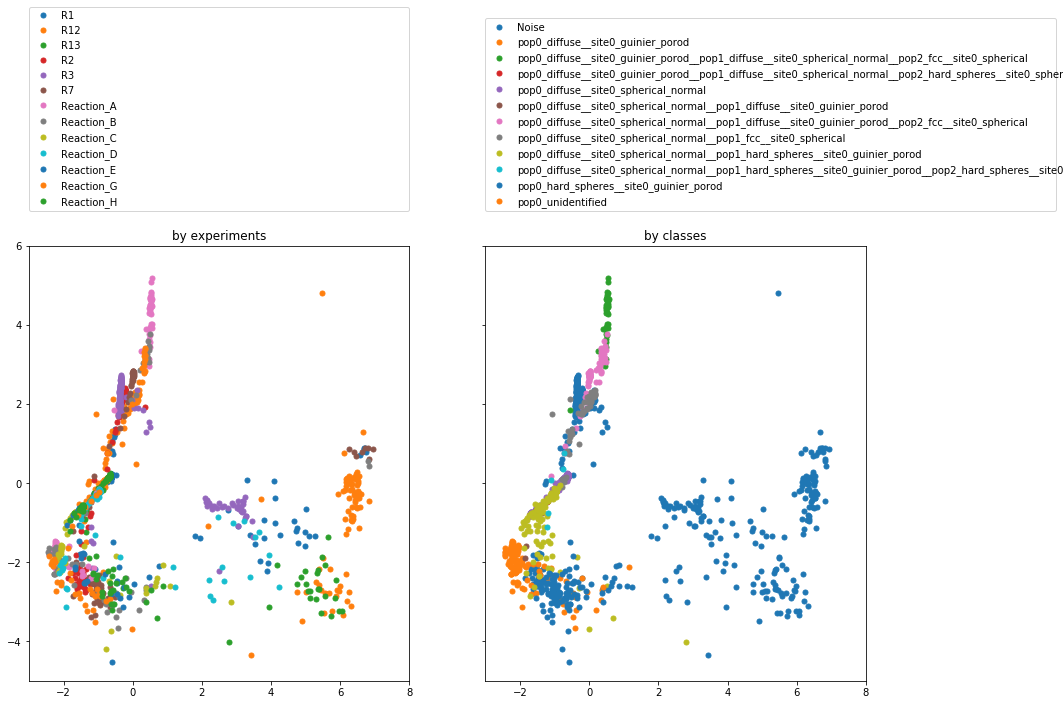

In [16]:
groups = vis_data.groupby('experiment_id')
groups2 = vis_data.groupby('system_class')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
    ax1.set_ylim([-5, 6])
    ax1.set_xlim([-3, 8])
ax1.set_title('by experiments')
ax1.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

for name, group in groups2:
    ax2.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
    ax2.set_ylim([-5, 6])
    ax2.set_xlim([-3, 8])
ax2.set_title('by classes')
ax2.legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

### Let explore the data from R12 and R1:

In [34]:
data_R12 = vis_data[vis_data['experiment_id']=='R12']
data_R12.system_class.value_counts()

Noise                                                                           145
pop0_diffuse__site0_spherical_normal                                            112
pop0_diffuse__site0_spherical_normal__pop1_fcc__site0_spherical                  40
pop0_diffuse__site0_spherical_normal__pop1_hard_spheres__site0_guinier_porod      7
pop0_hard_spheres__site0_guinier_porod                                            2
Name: system_class, dtype: int64

In [35]:
data_R1 = vis_data[vis_data['experiment_id']=='R1']
data_R1.system_class.value_counts()

pop0_diffuse__site0_spherical_normal                                            226
Noise                                                                            36
pop0_diffuse__site0_spherical_normal__pop1_hard_spheres__site0_guinier_porod     14
pop0_diffuse__site0_spherical_normal__pop1_fcc__site0_spherical                  14
pop0_hard_spheres__site0_guinier_porod                                            3
Name: system_class, dtype: int64

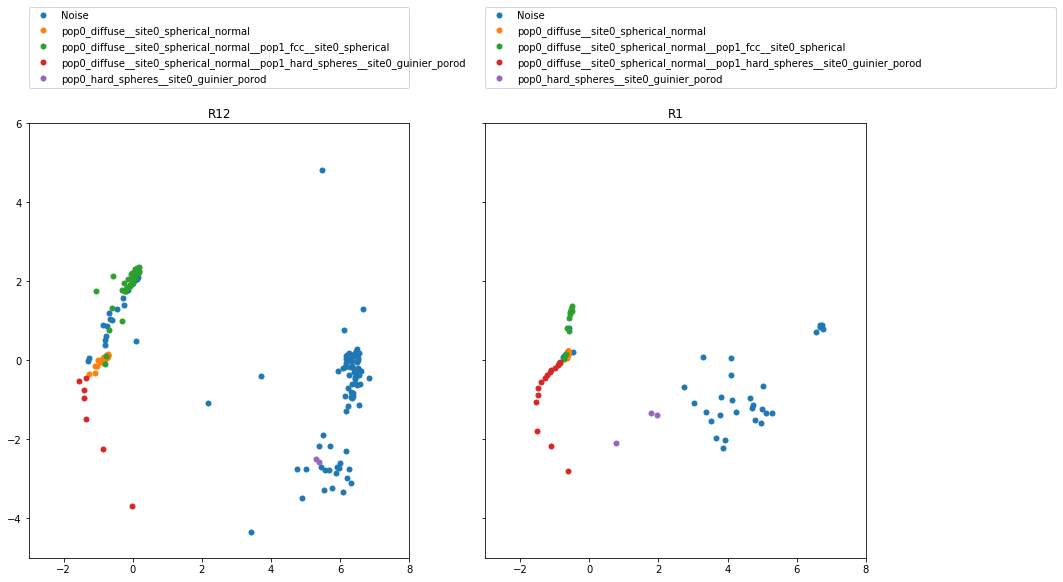

In [36]:
groups = data_R12.groupby('system_class')
groups2 = data_R1.groupby('system_class')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) 
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('R12')
ax1.set_ylim([-5, 6])
ax1.set_xlim([-3, 8])
ax1.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

for name, group in groups2:
    ax2.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('R1')
ax2.set_ylim([-5, 6])
ax2.set_xlim([-3, 8])
ax2.legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

### Goal: we want to remove the samples that are almost dublicates

## 1. Using abs difference between features.

In [38]:
sample_R12 = pd.DataFrame(columns=vis_data.columns)
for name, group in groups:
    df = pd.DataFrame(columns=vis_data.columns)
    df = df.append(group.iloc[0]) # add the first sample
    for i in range(1, group.shape[0]):
        add_row = True
        for j in range(0, df.shape[0]):
            #print(group.iloc[i][cols_to_scale])
            s = sum((group.iloc[i][cols_to_scale] - group.iloc[j][cols_to_scale]).abs())
            if s < 1:
                add_row = False 
        if add_row:
            df = df.append(group.iloc[i])
    sample_R12 = sample_R12.append(df)

In [39]:
sample_R12.shape

(108, 38)

In [40]:
sample_R1 = pd.DataFrame(columns=vis_data.columns)
for name, group in groups2:
    df = pd.DataFrame(columns=vis_data.columns)
    df = df.append(group.iloc[0])
    for i in range(1, group.shape[0]):
        add_row = True
        for j in range(0, df.shape[0]):
            s = sum((group.iloc[i][cols_to_scale] - group.iloc[j][cols_to_scale]).abs())
            if s < 1:
                add_row = False 
        if add_row:
            df = df.append(group.iloc[i])
    sample_R1 = sample_R1.append(df)

In [41]:
sample_R1.shape

(49, 38)

### Visualize "original" and redused data side by side:
## R12

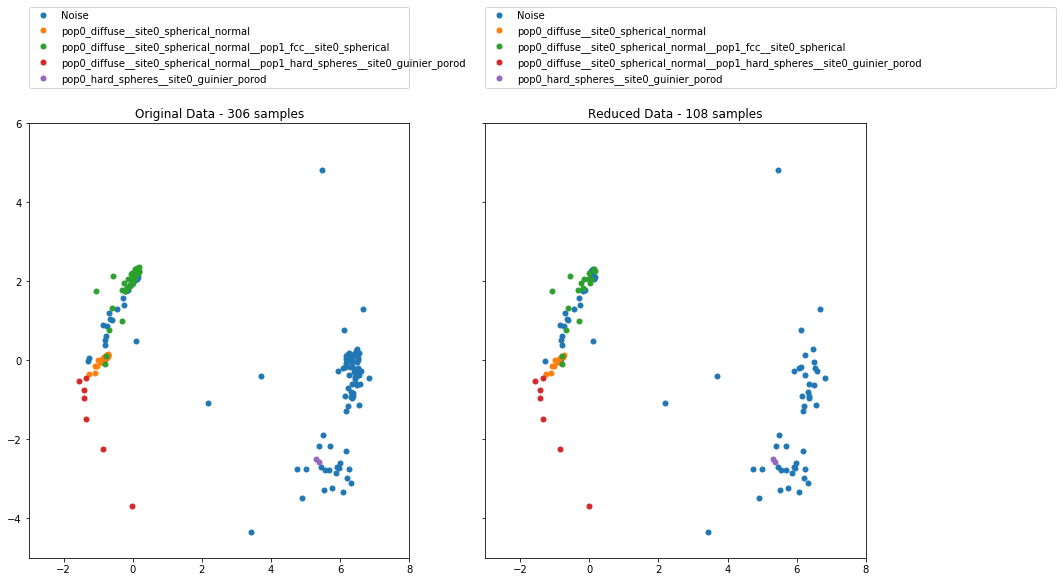

In [45]:
groups = data_R12.groupby('system_class')
groups2 = sample_R12.groupby('system_class')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) 
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('Original Data - 306 samples')
ax1.set_ylim([-5, 6])
ax1.set_xlim([-3, 8])
ax1.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

for name, group in groups2:
    ax2.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('Reduced Data - 108 samples')
ax2.set_ylim([-5, 6])
ax2.set_xlim([-3, 8])
ax2.legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

### R1

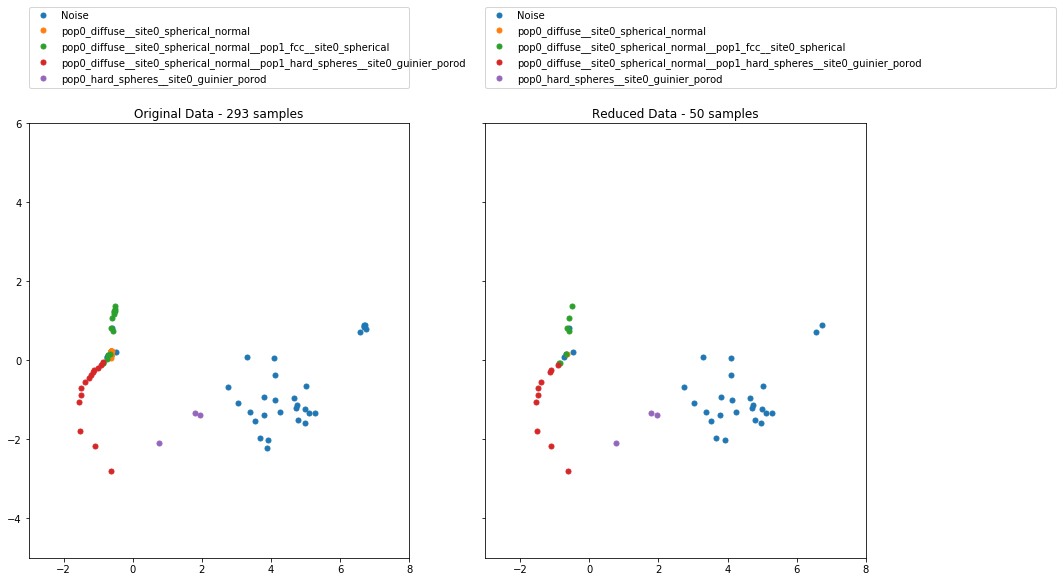

In [46]:
groups = data_R1.groupby('system_class')
groups2 = sample_R1.groupby('system_class')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) 
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('Original Data - 293 samples')
ax1.set_ylim([-5, 6])
ax1.set_xlim([-3, 8])
ax1.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

for name, group in groups2:
    ax2.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('Reduced Data - 50 samples')
ax2.set_ylim([-5, 6])
ax2.set_xlim([-3, 8])
ax2.legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

### Let's try it for all experiments

In [62]:
data_by_exp = {}
for exp_id in all_exp:
    df = vis_data[vis_data['experiment_id']==exp_id]
    data_by_exp[exp_id] = df

In [57]:
# make a sample from one experiment
def make_sample(data_fr):
    groups_by_class = data_fr.groupby('system_class')
    sample = pd.DataFrame(columns=vis_data.columns)
    for name, group in groups_by_class:
        df = pd.DataFrame(columns=vis_data.columns)
        df = df.append(group.iloc[0])
        for i in range(1, group.shape[0]):
            add_row = True
            for j in range(0, df.shape[0]):
                s = sum((group.iloc[i][cols_to_scale] - group.iloc[j][cols_to_scale]).abs())
                if s < 1:
                    add_row = False 
            if add_row:
                df = df.append(group.iloc[i])
        sample = sample.append(df)
    return sample

In [63]:
data_by_exp_samples = {}
for exp_id in all_exp:
    df = vis_data[vis_data['experiment_id']==exp_id]
    sample = make_sample(df)
    data_by_exp_samples[exp_id] = sample

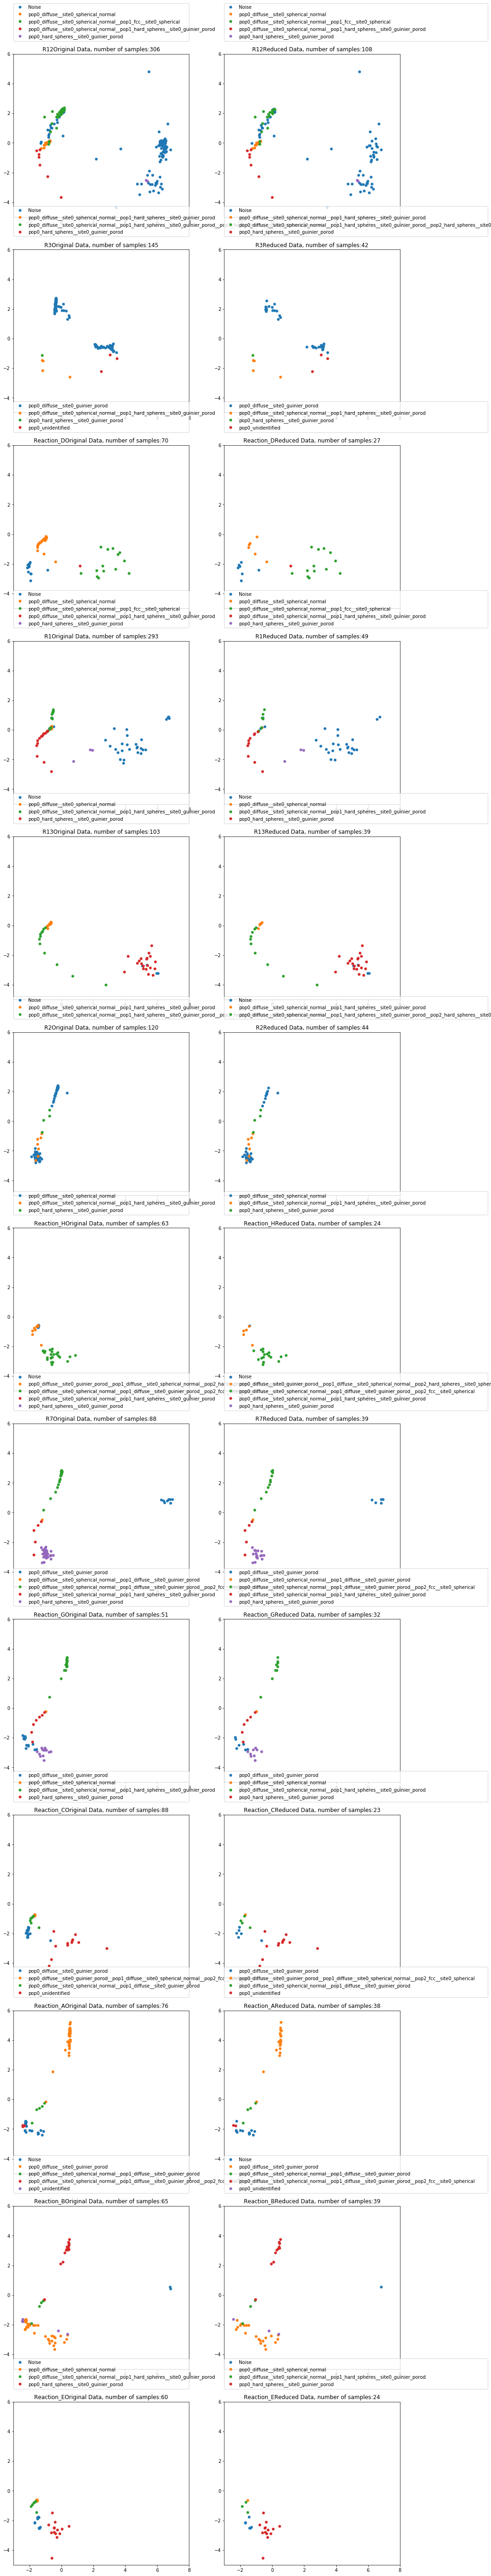

In [68]:
all_exp_subset = all_exp

fig, axes = plt.subplots(len(all_exp_subset), ncols=2, figsize=(15,100))
st.set_y(0.92)


for n in range(len(all_exp_subset)):
    e_id = all_exp_subset[n]
    groups = data_by_exp[e_id].groupby('system_class')
    groups2 = data_by_exp_samples[e_id].groupby('system_class')
    for name, group in groups:
        axes[n, 0].plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
    num_sm = data_by_exp[e_id].shape[0]
    num_sm_s = data_by_exp_samples[e_id].shape[0]
    axes[n, 0].set_title(e_id + 'Original Data, number of samples:'+ str(num_sm))
    axes[n, 0].set_ylim([-5, 6])
    axes[n, 0].set_xlim([-3, 8])
    axes[n, 0].legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

    for name, group in groups2:
        axes[n, 1].plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
    axes[n, 1].set_title(e_id + 'Reduced Data, number of samples:' + str(num_sm_s))
    axes[n, 1].set_ylim([-5, 6])
    axes[n, 1].set_xlim([-3, 8])
    axes[n, 1].legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

In [69]:
count = 0
for k,v in data_by_exp_samples.items():
    count+=v.shape[0]
count

528

## 2. Using k-mean algorithm

Again, for every experiment, I will group data by system_class. Then:
1. Use calinski_harabaz_score or silhouette_score to find the number of clusters.
2. Run k-mean with this number of clusters.
3. For every cluster return the sample closest to the center of cluster.

There is a library that includes about the same functionality:

http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html

But ClusterCentroids create equal number of clusters for every class and return the cluster centers (the generated samples). 

In [102]:
data_R12.system_class.unique()

array(['pop0_diffuse__site0_spherical_normal', 'Noise',
       'pop0_diffuse__site0_spherical_normal__pop1_fcc__site0_spherical',
       'pop0_diffuse__site0_spherical_normal__pop1_hard_spheres__site0_guinier_porod',
       'pop0_hard_spheres__site0_guinier_porod'], dtype=object)

In [127]:
d = data_R1[data_R1['system_class']=='Noise']

In [128]:
d.shape

(36, 38)

In [129]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score, silhouette_score

In [130]:
max_n_clusters = d.shape[0]
ch = []
sa = []
for k in range(2, max_n_clusters+1):
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(data[cols_to_scale])
    silhouette_avg = silhouette_score(data[cols_to_scale], cluster_labels)
    sa.append(silhouette_avg)
    
    calinski_harabaz_sc = calinski_harabaz_score(data[cols_to_scale], cluster_labels)
    ch.append(calinski_harabaz_sc)
    
for i in range(2, max_n_clusters+1):
    print("For n_clusters =", i, "The average silhouette_score is :", sa[i-2])
    
print()
for i in range(2, max_n_clusters+1):
    print("For n_clusters =", i, "calinski_harabaz_sc is :", ch[i-2])

For n_clusters = 2 The average silhouette_score is : 0.526026949785
For n_clusters = 3 The average silhouette_score is : 0.437146893735
For n_clusters = 4 The average silhouette_score is : 0.462135586495
For n_clusters = 5 The average silhouette_score is : 0.478896085428
For n_clusters = 6 The average silhouette_score is : 0.482008622791
For n_clusters = 7 The average silhouette_score is : 0.489282595173
For n_clusters = 8 The average silhouette_score is : 0.514594161014
For n_clusters = 9 The average silhouette_score is : 0.516731605955
For n_clusters = 10 The average silhouette_score is : 0.504521612636
For n_clusters = 11 The average silhouette_score is : 0.510690307649
For n_clusters = 12 The average silhouette_score is : 0.500540814091
For n_clusters = 13 The average silhouette_score is : 0.51467556426
For n_clusters = 14 The average silhouette_score is : 0.514730251421
For n_clusters = 15 The average silhouette_score is : 0.528375399536
For n_clusters = 16 The average silhouette_

In [131]:
max(ch)

821.86765967796782

In [132]:
max(sa)

0.56906085006019269

For pop0_diffuse__site0_spherical_normal__pop1_hard_spheres__site0_guinier_porod class, according to the calinski_harabaz_sc score, we should have all 14 samples, and according to the silhouette_score we should have 2 samples. 

For Noise class, according to the calinski_harabaz_sc score, we should have all 14 samples, and according to the silhouette_score we should have 32 samples. 

Thus, the idea of choosing the number of samples using these scores does not work :(

#### Conclusion

I think, the first approach could work better for our problem since we do not need to specify how much data we want to remove. The samples that are too similar are removed. 

We can change the threshold. When we will have a lot of data we can decrease threshold. In this case, only some unique datasamples will be kept. 